## Contour plots and integrals along and cross shelf of tracer concentration on shelf bottom  for runs with different diffusivity settings - canyon effect



Map hcw on shelf by looking at bottom cells and multiplying their concentration by their area (weighted averagem [C]), then integrating these along the shelf and cross-shelf ([C]/m). The canyon lid is not, strictly speaking, part of the shelf bottom, so I will leave it out of the average.

In this notebook: Contour plots of bottom tracer concentration anomailes (Base case - some run) for day 3 (around end of time dependent phase) and day 7 (during advective phase). Run 03 is the base case.


In [1]:
#KRM

import numpy as np

import matplotlib.gridspec as gspec

import matplotlib.pyplot as plt

from math import *

%matplotlib inline

from netCDF4 import Dataset

import seaborn as sns

import canyon_tools.readout_tools as rout

import canyon_tools.savitzky_golay as sg

In [2]:
# Seaborn set up
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [5]:
# Input files
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer03='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
PtracerOut03 = Dataset(Ptracer03)

Ptracer07='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'
PtracerOut07 = Dataset(Ptracer07)

Ptracer11='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11/ptracersGlob.nc'
PtracerOut11 = Dataset(Ptracer11)

Ptracer24='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run24/ptracersGlob.nc'
PtracerOut24 = Dataset(Ptracer24)

Ptracer12='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12/ptracersGlob.nc'
PtracerOut12 = Dataset(Ptracer12)

Ptracer25='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run25/ptracersGlob.nc'
PtracerOut25 = Dataset(Ptracer25)

Ptracer17='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run17/ptracersGlob.nc'
PtracerOut17 = Dataset(Ptracer17)

Ptracer30='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run30/ptracersGlob.nc'
PtracerOut30 = Dataset(Ptracer30)

Ptracer3D04='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/ptracersGlob.nc'
PtracerOut3D04 = Dataset(Ptracer3D04)

Ptracer3D05='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/ptracersGlob.nc'
PtracerOut3D05 = Dataset(Ptracer3D05)

Ptracer3D06='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/ptracersGlob.nc'
PtracerOut3D06 = Dataset(Ptracer3D06)

Ptracer3D07='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/ptracersGlob.nc'
PtracerOut3D07 = Dataset(Ptracer3D07)


In [6]:
# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

In [8]:
# Read in tracer fields
Tr03 = rout.getField(Ptracer03,'Tr1') # 
Tr11 = rout.getField(Ptracer11,'Tr2') # 
Tr12 = rout.getField(Ptracer12,'Tr3') # 
Tr17 = rout.getField(Ptracer17,'Tr3') # 

Tr07 = rout.getField(Ptracer07,'Tr1') # 
Tr24 = rout.getField(Ptracer24,'Tr1') # 
Tr25 = rout.getField(Ptracer25,'Tr1') # 
Tr30 = rout.getField(Ptracer30,'Tr1') # 

Tr3D04 = rout.getField(Ptracer3D04,'Tr1') # 
Tr3D05 = rout.getField(Ptracer3D05,'Tr1') # 
Tr3D06 = rout.getField(Ptracer3D06,'Tr1') # 
Tr3D07 = rout.getField(Ptracer3D07,'Tr1') # 

In [9]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    

    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (ConcArea,
            np.ma.masked_array(Conc, mask=maskShelf),
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

In [13]:
# Find bottom concentration, use the filtered output Conc#Filt
ConcArea03, Conc03, Conc03Filt, Area03 = ConcArea(Tr03, hFacC, rA, bathy)
ConcArea11, Conc11, Conc11Filt, Area11 = ConcArea(Tr11, hFacC, rA, bathy)
ConcArea12, Conc12, Conc12Filt, Area12 = ConcArea(Tr12, hFacC, rA, bathy)
ConcArea17, Conc17, Conc17Filt, Area17 = ConcArea(Tr17, hFacC, rA, bathy)

ConcArea07, Conc07, Conc07Filt, Area07 = ConcArea(Tr07, hFacCNoC, rA, bathyNoC)
ConcArea24, Conc24, Conc24Filt, Area24 = ConcArea(Tr24, hFacCNoC, rA, bathyNoC)
ConcArea25, Conc25, Conc25Filt, Area25 = ConcArea(Tr25, hFacCNoC, rA, bathyNoC)
ConcArea30, Conc30, Conc30Filt, Area30 = ConcArea(Tr30, hFacCNoC, rA, bathyNoC)

ConcArea3D04, Conc3D04, Conc3D04Filt, Area3D04 = ConcArea(Tr3D04, hFacC, rA, bathy)
ConcArea3D05, Conc3D05, Conc3D05Filt, Area3D05 = ConcArea(Tr3D05, hFacC, rA, bathy)
ConcArea3D06, Conc3D06, Conc3D06Filt, Area3D06 = ConcArea(Tr3D06, hFacC, rA, bathy)
ConcArea3D07, Conc3D07, Conc3D07Filt, Area3D07 = ConcArea(Tr3D07, hFacC, rA, bathy)

(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Anomalies with respect to base case

In [14]:
def plot_pool(fig,data,depths,tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'Purples',fill_col='SlateBlue' ):
    '''
    INPUT:
    fig: figure object
    data: 3d slice of output (np. array with t,y,x dimensions)
    depths: 2d array bathymetry, same size as data.
    tt: time index
    x_2d: 2d array of xc
    y_2d: 2d array of yc
    x_vect: 1d array of xc
    y_vect: 1d array of yc
    maxCM: max value for contourf colormap
    minCM: min value for contourf colormap
    cmap: string with the name of the colormap to use. Default is 'Purples'.
    fill_col: string with fill color for marginal line plots. Default is 'SlateBlue'.
    
    
    '''

    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    xmin = x_vect.min()
    xmax = x_vect.max()
    ymin = y_vect.min()
    ymax = y_vect.max()

    #Set style to white
    sns.set_style('white')

    #Define grid for subplots
    gs = gspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])

    #Create contour plot
    ax = plt.subplot(gs[1,0])
    caxf = ax.contourf(x_2d,y_2d,data,15, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap)
    
    bax = ax.contour(x_2d,y_2d,depths,[60,80,100,120,147.5], colors = '0.5')
    plt.clabel(bax, inline=1, fontsize=13)
    
    cax = ax.contour(x_2d,y_2d,data,7,colors = 'k')
    plt.clabel(cax, inline=1, fontsize=13)

    ax.set_xlabel('Alongshore distance [km]')
    ax.set_ylabel('Cross-shore distance [km]')

    #Turn on all axes
    ax.axis('on')

    #Create Y-marginal (right)
    axr = plt.subplot(gs[1,1], frameon = True,yticks=[],xlim=(data_mean_y.min(), data_mean_y.max()), ylim=(ymin, ymax) )
    axr.plot(data_mean_y, y_vect, color = 'black')
    axr.fill_betweenx(y_vect, 0, data_mean_y, alpha = .75, color = fill_col )
    axr.set_xlabel('mean BAC [(Mol/l)/m]')

    #Create X-marginal (top)
    axt = plt.subplot(gs[0,0], frameon = True, xticks=[], xlim = (xmin, xmax), ylim=(data_mean_x.min(), data_mean_x.max()))
    axt.plot(x_vect, data_mean_x, color = 'black')
    axt.fill_betweenx(data_mean_x, 0, x_vect, alpha = .75, color = fill_col)
    
    TEXT_OBJ = ax.text(1.1, 1.15, ('Day %1.1f ' %(tt/2.0)), transform=ax.transAxes, fontsize=20)
    
    #Bring the marginals closer to the contour plot
    fig.tight_layout(pad = 1)
    

Run 03 minus no canyon case


/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


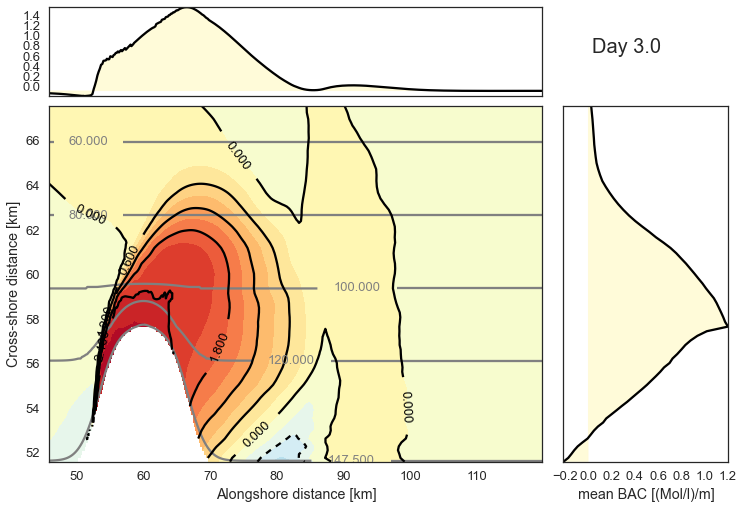

In [15]:
print('Run 03 minus no canyon case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc03Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 03 minus no canyon case


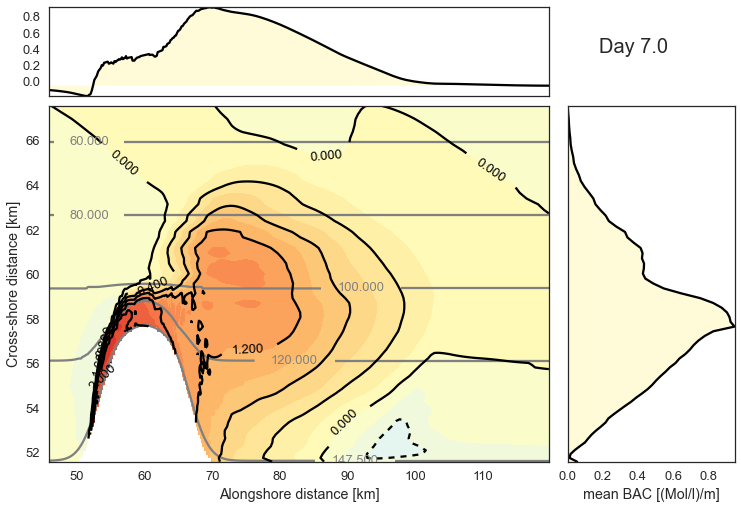

In [16]:
print('Run 03 minus no canyon case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc03Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 11 minus no canyon case


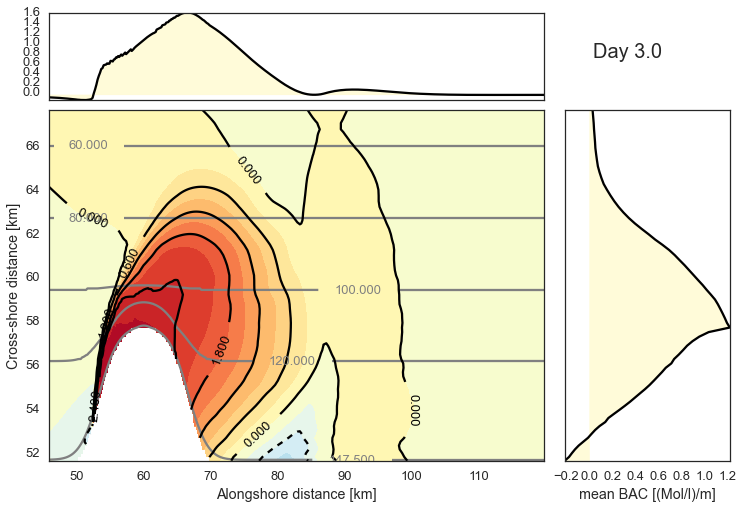

In [17]:
print('Run 11 minus no canyon case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc11Filt[tt,227:300,100:]-Conc24Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 11 minus noC case


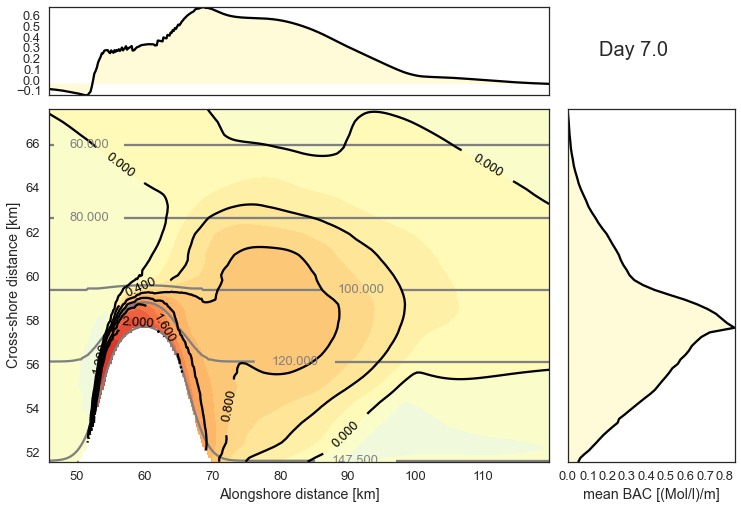

In [18]:
print('Run 11 minus noC case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc11Filt[tt,227:300,100:]-Conc24Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 12 minus noC case


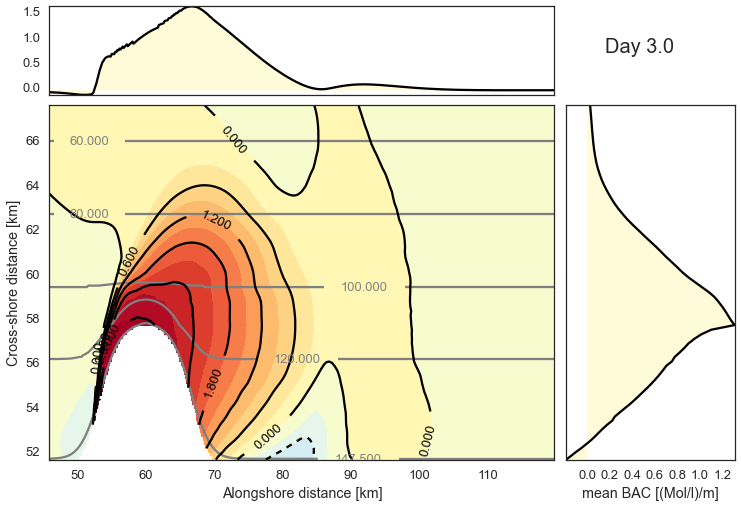

In [19]:
print('Run 12 minus noC case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc12Filt[tt,227:300,100:]-Conc25Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 12 minus NoC case


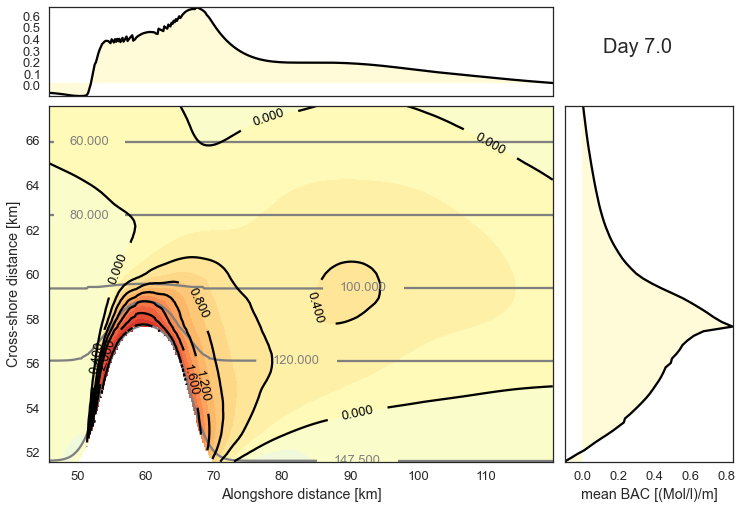

In [20]:
print('Run 12 minus NoC case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc12Filt[tt,227:300,100:]-Conc25Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 17 minus noC case


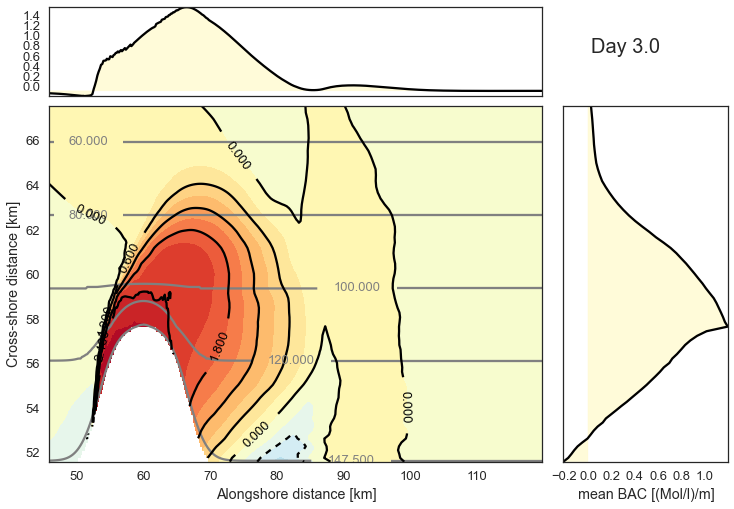

In [21]:
print('Run 17 minus noC case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc17Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 17 minus NoC case


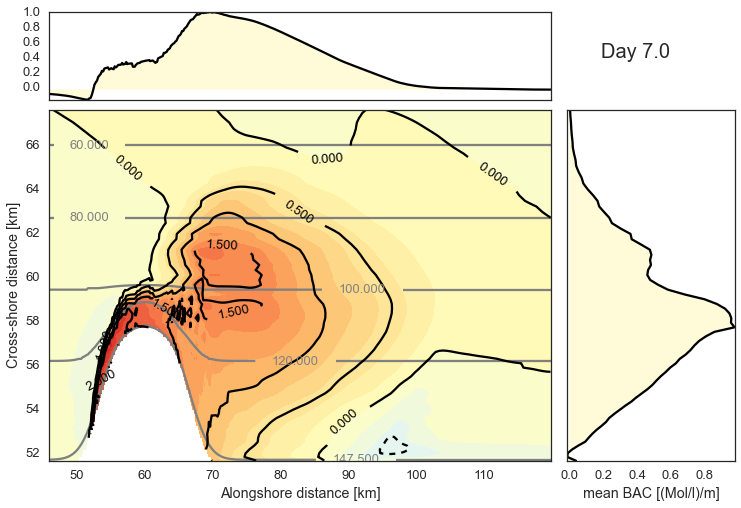

In [22]:
print('Run 17 minus NoC case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc17Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D04 minus noC case


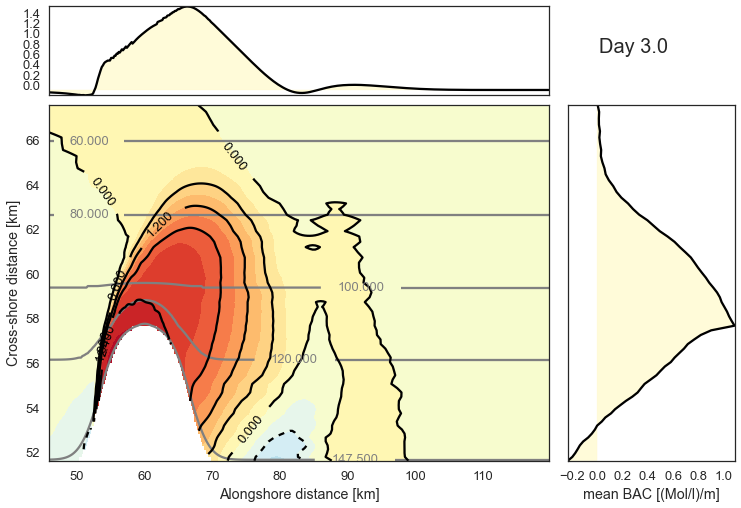

In [23]:
print('Run 3D04 minus noC case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D04Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D04 minus noc case


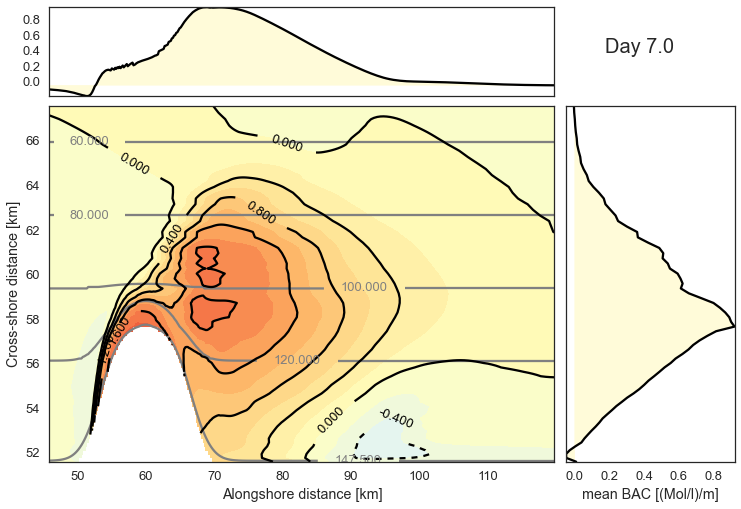

In [24]:
print('Run 3D04 minus noc case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D04Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D05 minus noc case


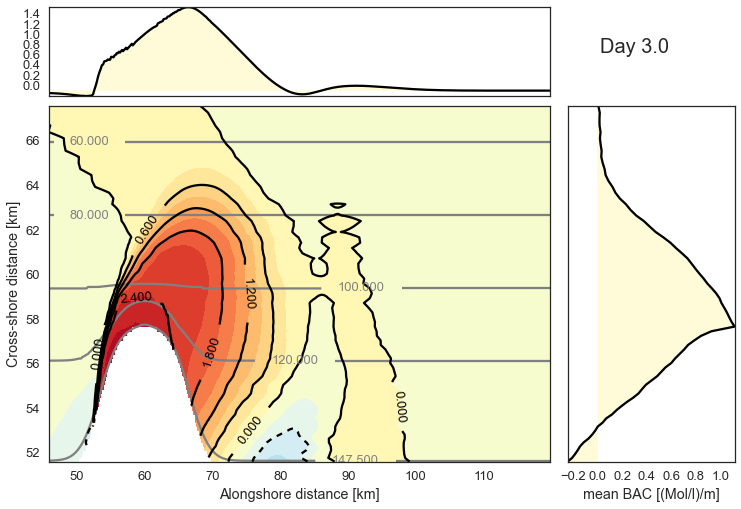

In [25]:
print('Run 3D05 minus noc case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D05Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D05 minus noc case


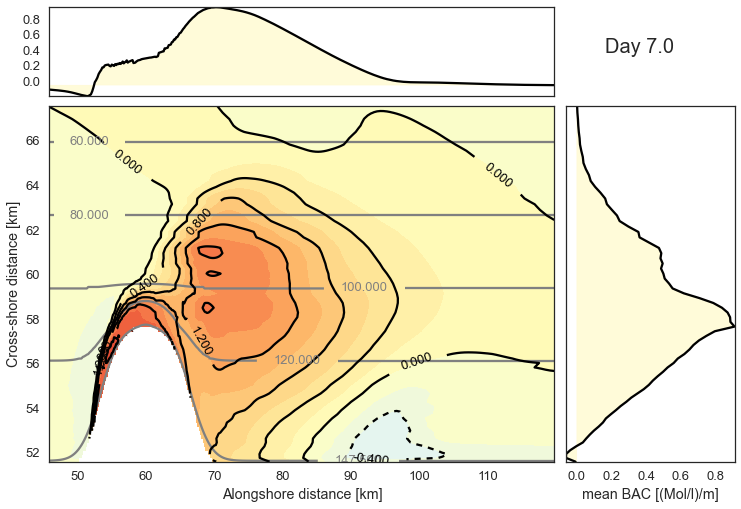

In [26]:
print('Run 3D05 minus noc case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D05Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D06 minus base case


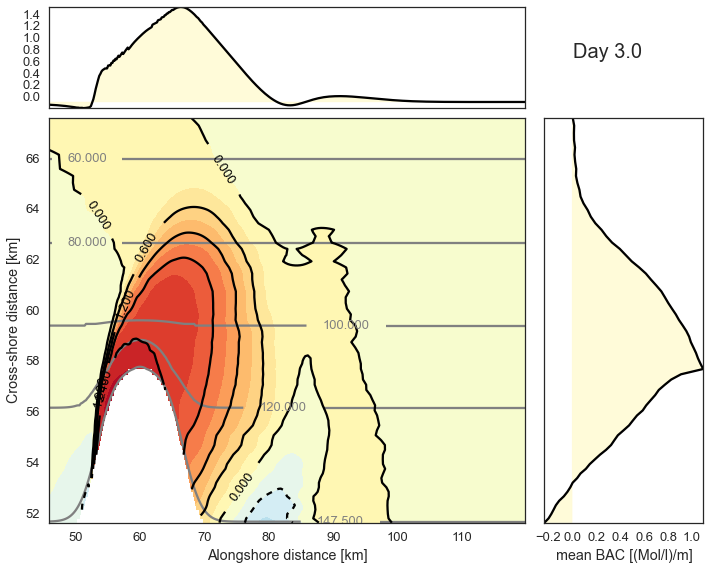

In [27]:
print('Run 3D06 minus base case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D06Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure(figsize = (10,8))
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D06 minus noc case


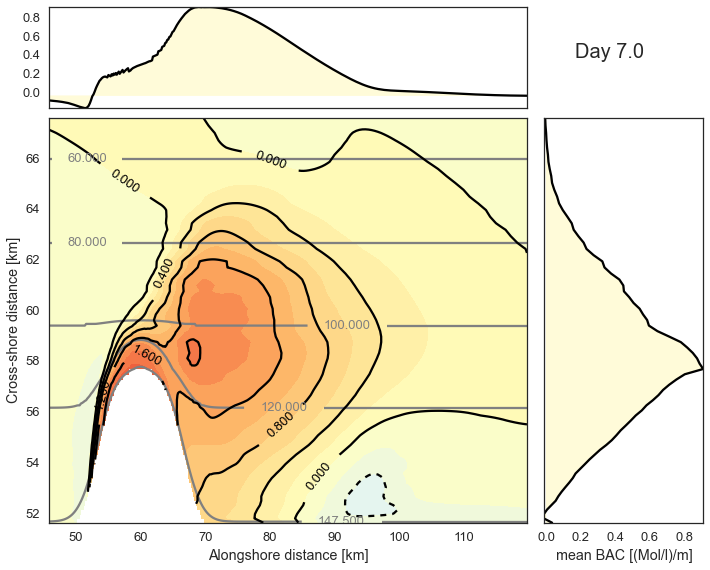

In [28]:
print('Run 3D06 minus noc case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D06Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure(figsize=(10,8))
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D07 minus NoC case


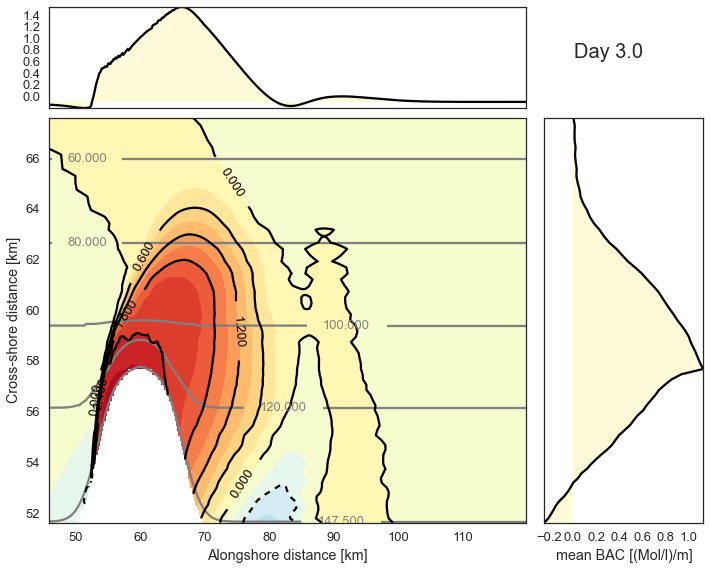

In [29]:
print('Run 3D07 minus NoC case')
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D07Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure(figsize = (10,8))
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Run 3D07 minus noc case


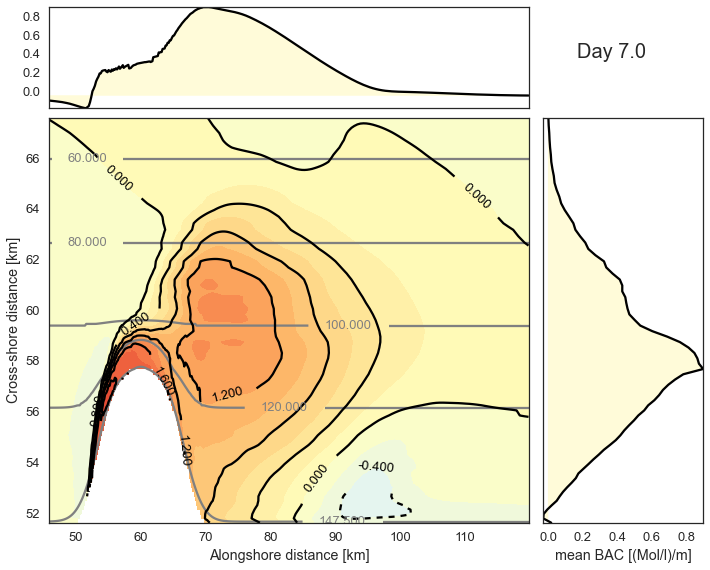

In [30]:
print('Run 3D07 minus noc case')
tt=14
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc3D07Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]
maxCM = 3.0
minCM = -3.0

fig = plt.figure(figsize=(10,8))
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


Anomalies


[]

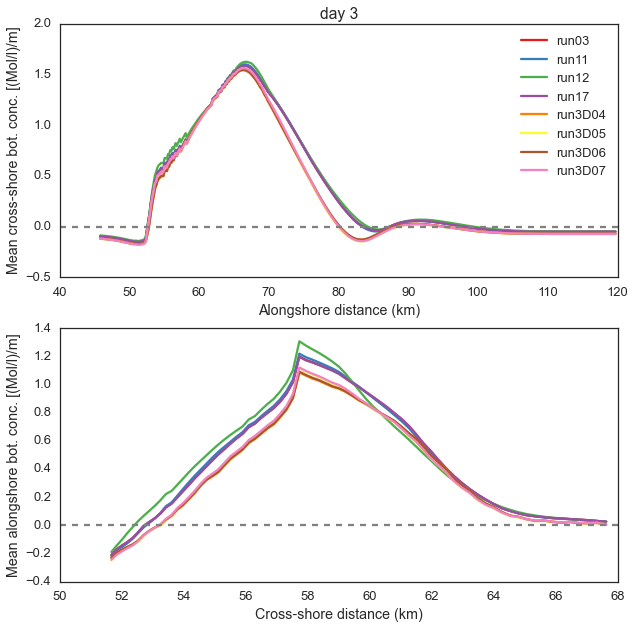

In [33]:
sns.set_palette('Set1',8)

print('Anomalies')
labels = ['run03','run11','run12','run17','run3D04','run3D05','run3D06','run3D07']

y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

tt=6
data_sets = [Conc03Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:],
             Conc11Filt[tt,227:300,100:]-Conc24Filt[tt,227:300,100:],
             Conc12Filt[tt,227:300,100:]-Conc25Filt[tt,227:300,100:],
             Conc17Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:],
             Conc3D04Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:],
             Conc3D05Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:],
             Conc3D06Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:],
             Conc3D07Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]]

data_mean_x = np.nanmean(data,axis=0)
data_mean_y = np.nanmean(data,axis=1)

fig,ax = plt.subplots(2,1,figsize=(10,10))

for data,lab in zip(data_sets,labels):
    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    ax[0].plot(x_vect,data_mean_x,label = lab)
    ax[1].plot(y_vect,data_mean_y,label = lab)

ax[0].axhline(0, color='0.5', linestyle = '--')
ax[1].axhline(0, color='0.5', linestyle = '--')

ax[0].set_ylabel('Mean cross-shore bot. conc. [(Mol/l)/m]')
ax[1].set_ylabel('Mean alongshore bot. conc. [(Mol/l)/m]')
ax[0].set_xlabel('Alongshore distance (km)')
ax[1].set_xlabel('Cross-shore distance (km)')
ax[0].set_title('day 3')
ax[0].legend(loc=0)
plt.plot()

Anomalies


[]

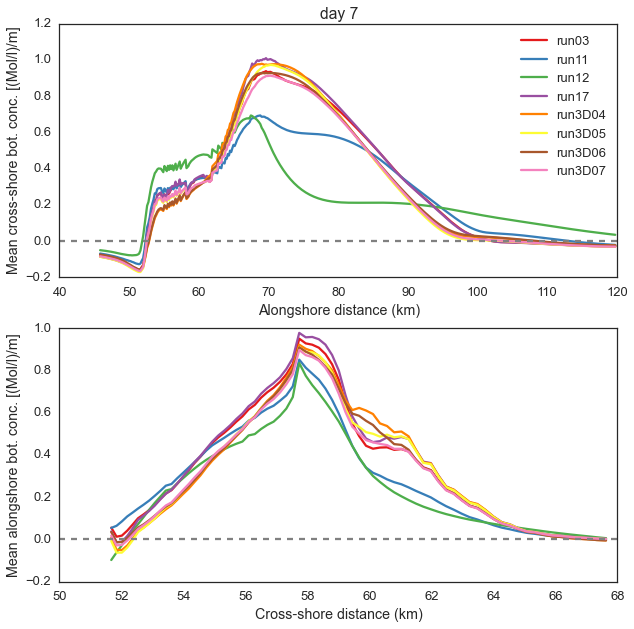

In [34]:
print('Anomalies')
labels = ['run03','run11','run12','run17','run3D04','run3D05','run3D06','run3D07']

y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

tt=14
data_sets = [Conc03Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:],
             Conc11Filt[tt,227:300,100:]-Conc24Filt[tt,227:300,100:],
             Conc12Filt[tt,227:300,100:]-Conc25Filt[tt,227:300,100:],
             Conc17Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:],
             Conc3D04Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:],
             Conc3D05Filt[tt,227:300,100:]-Conc30Filt[tt,227:300,100:],
             Conc3D06Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:],
             Conc3D07Filt[tt,227:300,100:]-Conc07Filt[tt,227:300,100:]]

data_mean_x = np.nanmean(data,axis=0)
data_mean_y = np.nanmean(data,axis=1)

fig,ax = plt.subplots(2,1,figsize=(10,10))

for data,lab in zip(data_sets,labels):
    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    ax[0].plot(x_vect,data_mean_x,label = lab)
    ax[1].plot(y_vect,data_mean_y,label = lab)

ax[0].axhline(0, color='0.5', linestyle = '--')
ax[1].axhline(0, color='0.5', linestyle = '--')

ax[0].set_ylabel('Mean cross-shore bot. conc. [(Mol/l)/m]')
ax[1].set_ylabel('Mean alongshore bot. conc. [(Mol/l)/m]')
ax[0].set_xlabel('Alongshore distance (km)')
ax[1].set_xlabel('Cross-shore distance (km)')
ax[0].set_title('day 7')
ax[0].legend(loc=0)
plt.plot()